In [245]:
import os
import json
import pandas as pd
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
from joblib import Parallel, delayed
import matplotlib
%matplotlib inline
from PIL import Image, ImageSequence

In [148]:
import braindrlesdeep

In [58]:
Vote = namedtuple('Vote', 'response sample time user')
LabeledSample = namedtuple('LabeledSample', 'sample truth')

In [59]:
def readVotes():
    filename = 'braindrles-votes-export.json'
    path = os.path.join('data', filename)
    with open(path) as reader:
        votes = json.load(reader)
    output = []
    for _id in votes:
        vote = votes[_id]
        try:
            output.append(Vote(**vote))
        except Exception as e:
            print("Unable to parse a vote json. Error: ", str(e))
    return output

In [60]:
def readGoldLabels():
    filename = 'braindrles-sampleTruths-export.json'
    path = os.path.join('data', filename)
    with open(path) as reader:
        samples = json.load(reader)
    output = []
    for sample_id in samples:
        sample = LabeledSample(sample=sample_id, truth=samples[sample_id]['truth'])
        output.append(sample)
    return output


In [61]:
labeled_data_raw = readGoldLabels()
votes_raw = readVotes()

Unable to parse a vote json. Error:  __new__() missing 1 required positional argument: 'user'


In [62]:
votes = pd.DataFrame(votes_raw)
labeled_data = pd.DataFrame(labeled_data_raw)

In [63]:
votes.rename(columns={'sample': 'image_id', 'user': 'username', 'response': 'vote'}, inplace=True)
labeled_data.rename(columns={'sample': 'image_id', 'user': 'username'}, inplace=True)

In [64]:
BRAINDRLES_DATA_PATH = os.path.join('data', 'braindrles_votes_data.csv')
BRAINDRLES_GOLD_PATH = os.path.join('data', 'braindrles_gold_data.csv')
votes.to_csv(BRAINDRLES_DATA_PATH, index=False)
labeled_data.to_csv(BRAINDRLES_GOLD_PATH, index=False)

In [65]:
average_rating_by_user = votes.groupby(['image_id', 'username']).apply(lambda x: x.mean()[['vote']]).reset_index()
average_rating_by_user.head()

,image_id,username,vote
0,gifbrles_031768,bookworm,1.000000
1,gifbrles_031769,EvieD,0.333333
2,gifbrles_031769,Linztogo,0.000000
3,gifbrles_031769,Regina Phalange,1.000000
4,gifbrles_031769,Tatiana,1.000000


In [66]:
average_rating_of_image = average_rating_by_user.groupby(['image_id']).apply(lambda x: x.mean()[['vote']]).reset_index()
average_rating_of_image.head()

,image_id,vote
0,gifbrles_031768,1.000000
1,gifbrles_031769,0.448718
2,gifbrles_031770,0.933333
3,gifbrles_031771,1.000000
4,gifbrles_031772,0.872727


In [67]:
count_of_users_rated_each_image = average_rating_by_user.groupby(['image_id']).apply(lambda x: x.count()[['vote']]).reset_index()
count_of_users_rated_each_image.rename(columns={'vote': 'count_of_users'}, inplace=True)
count_of_users_rated_each_image.head()

,image_id,count_of_users
0,gifbrles_031768,1
1,gifbrles_031769,13
2,gifbrles_031770,5
3,gifbrles_031771,5
4,gifbrles_031772,11


In [68]:
positive_subject_names = labeled_data[labeled_data.truth == 1]['image_id'].values
negative_subject_names = labeled_data[labeled_data.truth == 0]['image_id'].values

In [69]:
average_rating_by_user_with_pos_true_label = average_rating_by_user[average_rating_by_user['image_id'].isin(positive_subject_names)]
average_rating_by_user_with_neg_true_label = average_rating_by_user[average_rating_by_user['image_id'].isin(negative_subject_names)]

average_rating_by_user_with_pos_true_label.loc[:,'truth'] = 1
average_rating_by_user_with_neg_true_label.loc[:,'truth'] = 0

data_with_true_labels = average_rating_by_user_with_pos_true_label.append(average_rating_by_user_with_neg_true_label, ignore_index = True)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Pre-processed data form
`data_with_true_labels` is a dataframe which contains the average rating of a user for a particular image and along with the true label in each row. Use this dataframe for all tasks.

In [70]:
data_with_true_labels.head()

,image_id,username,vote,truth
0,gifbrles_031772,Franky,1.0,1
1,gifbrles_031772,Garvita,1.0,1
2,gifbrles_031772,KirstieJane,1.0,1
3,gifbrles_031772,Regina Phalange,1.0,1
4,gifbrles_031772,Tlow,1.0,1


In [71]:
positive_sample_size = len(positive_subject_names)
negative_sample_size = len(negative_subject_names)

print("Positive sample size : ", positive_sample_size)
print("Negative sample size : ", negative_sample_size)

Positive sample size :  157
Negative sample size :  68


### Maximum accuracy one can get by marking every image as positive/negative.

Ideally we should not consider the votes of users who have accuracy below than this threshold accuracy.

In [72]:
threshold_accuracy = (100.0* max(positive_sample_size, negative_sample_size)) / (positive_sample_size + negative_sample_size)
threshold_accuracy

69.77777777777777

## How accurate a particular user's reponses are?

In [73]:
is_pred_correct_df = data_with_true_labels.copy()
is_pred_correct_df['is_correct'] = is_pred_correct_df.apply(lambda row: 1 if row['vote'] == row['truth'] else 0, axis=1)
accuracy_df = is_pred_correct_df.groupby(['username']).agg({'is_correct': ['sum', 'count']})

levels = accuracy_df.columns.levels
labels = accuracy_df.columns.codes
accuracy_df.columns = levels[1][labels[1]]
accuracy_df = accuracy_df.reset_index()
accuracy_df = accuracy_df.rename(columns={'count':'total_swipes', 'sum': 'correct_swipes'})

accuracy_df['accuracy_in_percent'] = (100.0*accuracy_df['correct_swipes'])/accuracy_df['total_swipes']
accuracy_df = accuracy_df.sort_values(['accuracy_in_percent', 'total_swipes'], ascending=False)[['username', 'correct_swipes', 'total_swipes', 'accuracy_in_percent']]

accuracy_df.head(n=15)

,username,correct_swipes,total_swipes,accuracy_in_percent
1,BrainDK,19,19,100.000000
10,Lindamilla,9,9,100.000000
9,Kkotake,1,1,100.000000
33,mikeb,22,23,95.652174
18,Tlow,73,77,94.805195
16,Tatiana,31,33,93.939394
6,Galothus,60,64,93.750000
21,akeshavan,73,79,92.405063
17,Tester12345,12,13,92.307692
45,zavalian,43,48,89.583333


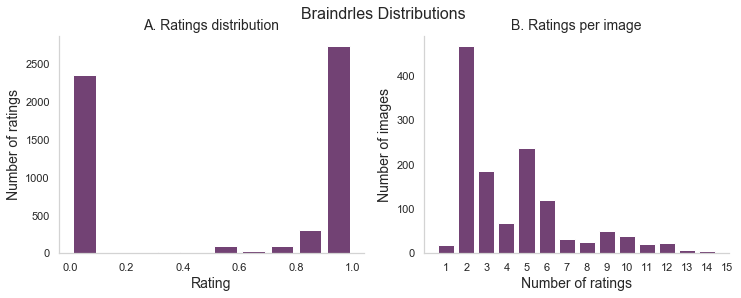

In [74]:
sns.set_style('white')
sns.set_palette(sns.color_palette("Set2", 10))
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.despine(fig)
colors = sns.cubehelix_palette(10, light=1)[::-1]

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

c,x,bars = ax[0].hist(average_rating_by_user.vote.values, rwidth=0.8, bins=10, color=colors[2]);
ax[0].set_xlabel('Rating', fontsize=14)
ax[0].set_ylabel('Number of ratings', fontsize=14)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_title('A. Ratings distribution', fontsize=14)

ax[1].hist(count_of_users_rated_each_image.count_of_users.values, rwidth=0.8, bins = range(1, count_of_users_rated_each_image.count_of_users.max()), color=colors[2])
ax[1].set_ylabel('Number of images', fontsize=14)
ax[1].set_title('B. Ratings per image', fontsize=14)
ax[1].set_xlabel('Number of ratings', fontsize=14)
ax[1].set_xticks(np.arange(1, count_of_users_rated_each_image.count_of_users.max())+0.5)
ax[1].set_xticklabels(np.arange(1, count_of_users_rated_each_image.count_of_users.max()))

plt.suptitle('Braindrles Distributions', fontsize=16);
plt.savefig('BraindrlesDistributions.svg')


### Count user contribution. Drop all users which are below 50 percentile.

In [79]:
# user_counts = data_with_true_labels.groupby('username').apply(lambda x: x.shape[0])
# username_keep = user_counts[user_counts >= user_counts.describe()['50%']].index.values
# username_keep

In [77]:
# votes_by_hard_working_users = data_with_true_labels[data_with_true_labels.username.isin(username_keep)]
# votes_by_hard_working_users.head()

### Convert the dataframe into a pivot table, where each row will correspond to a particular image and columns are votes by a user.

This table contains images for which we have a gold standard label.

In [78]:
# pivot_table_small = votes_by_hard_working_users.pivot_table(columns="username", index='image_id', values='vote')
# true_labels = votes_by_hard_working_users.groupby('image_id').apply(lambda x: x.truth.values[0])
# pivot_table_small['truth'] = true_labels

# plain_avg = pivot_table_small[pivot_table_small.columns[:-1]].mean(1)
# pivot_table_small['plain_average'] = plain_avg

# pivot_table_small.head()

## XGBoost Model Training

In [80]:

learning_rate = [0.01, 0.1]
n_estimators = [600]
max_depth = [2, 6]
test_size = 0.33

agg_data = braindrlesdeep.aggregate_braindr_votes(BRAINDRLES_DATA_PATH, 
                                      positive_subject_names,
                                      negative_subject_names,
                                      learning_rate, n_estimators, 
                                      max_depth, test_size)

/Users/amit/WorkPro/npnl/brainderless/phase-1/braindrlesdeep/braindrlesdeep.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  braindr_df_pass_subset['truth'] = 1
/Users/amit/WorkPro/npnl/brainderless/phase-1/braindrlesdeep/braindrlesdeep.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  braindr_df_fail_subset['truth'] = 0
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 a

### Get ROC curve of the model on the labelled data

In [83]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(agg_data):
    fpr, tpr, t = roc_curve(np.asarray(agg_data['y_test'])== 1, np.asarray(agg_data['y_pred_prob']))
    a = auc(fpr, tpr)
    
    df = pd.DataFrame(json.loads(agg_data['bdr_pivot']))
    fprt, tprt, tt = roc_curve(df.truth.values == 1, df.plain_average.values)
    aa = auc(fprt, tprt)
    output = dict(fpr=fpr, tpr=tpr, thresholds=t, auc=a, train_size=agg_data['X_train_shape'][0],
                  fpr_a=fprt, tpr_a=tprt, thresholds_a = tt, auc_a = aa)
    return output


In [84]:
output = get_roc_auc(agg_data)
print(output['auc'])

0.9268394648829432


In [85]:
def iterate_test_size(test_size):
    import requests
    
    braindr_path = BRAINDRLES_DATA_PATH

    learning_rate = [0.01, 0.1]
    n_estimators = [600]
    max_depth = [2, 6]

    agg_data = braindrlesdeep.aggregate_braindr_votes(braindr_path, 
                                      positive_subject_names,
                                      negative_subject_names,
                                      learning_rate, n_estimators, 
                                      max_depth, test_size)
    return agg_data

In [86]:
test_sizes = [0.2, 0.33, 0.5, 0.75]

data_all = Parallel(n_jobs=2)(delayed(iterate_test_size)(i) for i in test_sizes)

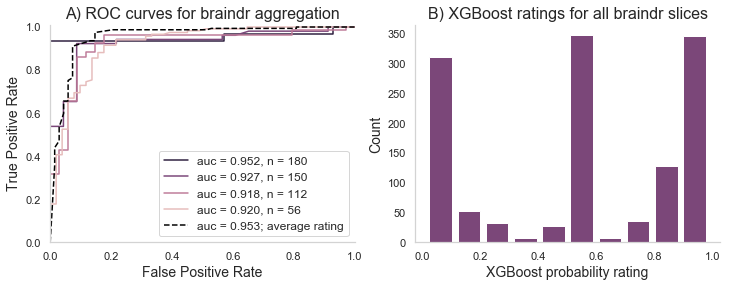

In [87]:
rocs = [get_roc_auc(d) for d in data_all]
#colors = sns.light_palette((210, 90, 60), input="husl")[::-1]
colors = sns.cubehelix_palette(5, light=1)[::-1]

with sns.color_palette(colors):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].spines['bottom'].set_color('lightgray')
    ax[0].spines['left'].set_color('lightgray')
    ax[1].spines['bottom'].set_color('lightgray')
    ax[1].spines['left'].set_color('lightgray')
    sns.despine(fig)
    for i, roc in enumerate(rocs):
        ax[0].plot(roc['fpr'], roc['tpr'])
        ax[0].set_xlim([0,1])
        ax[0].set_ylim([0,1.01])
        
    ax[0].plot(roc['fpr_a'], roc['tpr_a'], color="black", linestyle="--")
    ax[0].legend(["auc = %0.3f, n = %d" % (roc['auc'], 
                                        roc['train_size']) for roc in rocs] +\
              ["auc = %0.3f; average rating" % rocs[0]['auc_a']], loc=4, fontsize=12)
    ax[0].set_xlabel('False Positive Rate', fontsize=14)
    ax[0].set_ylabel('True Positive Rate', fontsize=14)
    ax[0].set_title("A) ROC curves for braindr aggregation", fontsize=16)
    
    output = pd.DataFrame(json.loads(agg_data['output']))
    ax[1].hist(output.xgboost_label.values, rwidth=0.8, color=colors[1])
    ax[1].set_xlabel('XGBoost probability rating', fontsize=14)
    ax[1].set_ylabel('Count', fontsize=14)
    ax[1].set_title('B) XGBoost ratings for all braindr slices', fontsize=16)

Text(0.5,0.98,'Rater Importance from XGBoost Model')

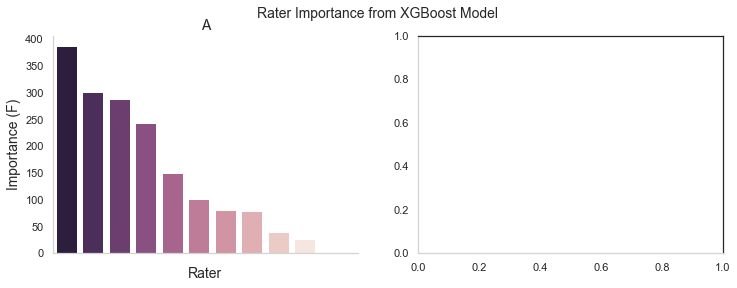

In [88]:
fdf = pd.DataFrame(json.loads(agg_data['user_importance']))
fdf.sort_values('F', inplace=True)
fdf.rename(columns={"user": "username"}, inplace=True)
fdf = fdf[::-1]
fdf['idx'] = np.arange(1, 1+fdf.shape[0])
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].spines['top'].set_visible(False)
#ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(True)

ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(fdf.shape[0], light=1)[::-1]

ax[0].bar(np.arange(fdf.shape[0]), fdf.F.values, color=colors)
ax[0].set_xticks(np.arange(fdf.shape[0]))
ax[0].set_xticklabels([]) #fdf.idx.values, fontsize=8);
#ax[0].set_yticks([])
ax[0].set_xlabel("Rater", fontsize=14)
ax[0].set_ylabel("Importance (F)", fontsize=14)
ax[0].set_xlim([-0.5,fdf.shape[0]])
ax[0].set_title("A", fontsize=14)


# sns.despine(ax=ax[1])

# ucounts = bdr_raters_gold.groupby('username').apply(lambda x: x.shape[0])
# fdf.set_index('username', inplace=True)
# fdf['ucounts'] = ucounts

# ax[1].scatter(fdf.ucounts.values, fdf.F.values, c=colors, edgecolors="lightgray")
# ax[1].set_xlabel("# Ratings in Gold Standard", fontsize=14)
# ax[1].set_ylabel("Importance (F)", fontsize=14)
# ax[1].set_title("B", fontsize=16)


# from matplotlib.patches import Circle
# from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
#                                   AnnotationBbox)
# from matplotlib.cbook import get_sample_data

plt.suptitle("Rater Importance from XGBoost Model", fontsize=14)
#for i, row in fdf.iterrows():
#  ax.text(row.F+1, idx-0.15, str(row.F))
#  idx +=1

In [132]:
output = pd.DataFrame(json.loads(agg_data['output']))
bdr_gold = pd.DataFrame(json.loads(agg_data['bdr_pivot']))
img_labels = pd.DataFrame({'subject': output.index, 'y_prob': output.xgboost_label.values, 'idx': np.arange(output.shape[0])}, index = output.index)
img_labels.head()


,subject,y_prob,idx
gifbrles_031768,gifbrles_031768,0.828926,0
gifbrles_031769,gifbrles_031769,0.941839,1
gifbrles_031770,gifbrles_031770,0.869201,2
gifbrles_031771,gifbrles_031771,0.966118,3
gifbrles_031772,gifbrles_031772,0.928558,4


In [130]:
gold = pd.merge(img_labels[['idx']], bdr_gold[['truth', 'plain_average']], 
                left_index=True, right_index=True)

In [108]:
def readImages(img_labels):
    output = []
    for i in range(img_labels.shape[0]):
        filename = "{0}.gif".format(img_labels.iloc[i]['subject'])
        output.append(filename)
    return output

In [150]:
X = readImages(img_labels)
y = img_labels['y_prob']

In [124]:
# This step would take time.
X_vgg = convertToVGG(X)

In [ ]:
# Save the images that are transformed using the VGG model to disk
model_ouput = {}
model_output['X'] = X
model_output['X_vgg'] = X_vgg
model_output['labels'] = img_labels.subject.values
np.savez('/data/braindrles_slice_data.npz', **model_output)

In [145]:
!mkdir scratch/braindr_vgg16

In [267]:
results = braindrlesdeep.run_model(X_vgg, y, img_labels, gold, out_path="./scratch/braindr_vgg16")


In [ ]:
all_predicted = results['model'].predict(X_vgg)

In [ ]:
img_labels['predicted_label'] = all_predicted

In [ ]:
all_results = []

for i in range(1,10):
    r = ba.run_model(X_vgg, y, img_labels, gold, out_path="/mnt/scratch3/keshavan/braindr_vgg16", i=i)
    all_results.append(r)

In [ ]:
k = [a['auc'] for a in all_results + [results]]
print(np.mean(k), np.std(k))

In [ ]:
a = all_results[0]['train_idx']
b = all_results[1]['train_idx']

In [ ]:
# Make sure the training sets for different seed runs actually have different subjects
assert ~np.asarray([i in b for i in a]).all()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].spines['bottom'].set_color('lightgray')
ax[0].spines['left'].set_color('lightgray')
ax[1].spines['bottom'].set_color('lightgray')
ax[1].spines['left'].set_color('lightgray')

colors = sns.cubehelix_palette(10, light=1)[::-1]

sns.despine(fig)
for i, a in enumerate(all_results + [results]):
    if not i:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1], 
                   label="%0.3f +- %0.3f; vgg16" % (np.mean(k), np.std(k)))
    else:
        ax[1].plot(a['fpr'], a['tpr'], alpha=0.5, color=colors[1])

    
    
ax[1].plot(rocs[1]['fpr'], rocs[1]['tpr'],color=colors[6], 
           label="%0.3f; xgboost" % rocs[1]['auc'], linewidth=3)
ax[1].plot(rocs[1]['fpr_a'], rocs[1]['tpr_a'], color=colors[8], 
           label="%0.3f; average" % rocs[1]['auc_a'], linewidth=3)
ax[1].set_xlim([-0.01,1])
ax[1].set_ylim([0,1.01])
ax[1].legend(fontsize=12, loc=4)
ax[1].spines['left'].set_visible(False)
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel("True Positive Rate", fontsize=14)
ax[1].set_title("B) ROC curves", fontsize=14)
    
tdf = results['training']
ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])
ax[0].legend(fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Mean squared error loss', fontsize=14)
ax[0].set_title("A) Training top layer of VGG16", fontsize=14)

for res in all_results:
    tdf = res['training']
    ax[0].plot(tdf.epoch.values, tdf.loss.values, label="training loss", linewidth=1, color=colors[2])
    ax[0].plot(tdf.epoch.values, tdf.val_loss.values, label="validation loss", linewidth=1, color=colors[7])

In [ ]:
braindr_vgg_train = {'vgg': [], 'crowd': rocs[1]}
for a in all_results + [results]:
    entry = {}
    for key in ['fpr', 'tpr', 'threshold', 'auc']:
        try:
            entry[key] = a[key].tolist()
        except:
            entry[key] = a[key]
    entry['training'] = a['training'].to_json(orient="records")
    braindr_vgg_train['vgg'].append(entry)
save_json("data/braindrles_vgg_results.json", braindr_vgg_train)

In [191]:
def downloadImage(image_name_with_ext, ):
    s3_url = 'https://s3-us-west-1.amazonaws.com/braindrlesgifs/'
    src_url = "{0}{1}".format(s3_url, image_name_with_ext)
    dest = os.path.join('data', 'images', image_name_with_ext)
    cmd = "wget {0} -O {1}".format(src_url, dest)
    os.system(cmd)

In [251]:
def convertGifToNumpy(image_path):
    img = Image.open(image_path)
    return np.array([np.array(frame.copy().convert('RGB').getdata(),dtype=np.uint8).reshape(frame.size[1],frame.size[0],3) for frame in ImageSequence.Iterator(img)])

In [254]:
def downloadAndLoadImages(image_names):
    print("Downloading the GIF images if not present locally")
    all_images = []
    for index, image_name in enumerate(image_names):
        image_name_with_ext = "{0}.gif".format(image_name)
        image_path = os.path.join('data', 'images', image_name_with_ext)
        if not os.path.exists(image_path):
            downloadImage(image_name_with_ext)
        all_images.append(convertGifToNumpy(image_path))
        if index % 100 == 0:
            print("Loaded {0} images till now".format(index+1))
    return np.array(all_images)

In [264]:
gif_image_data = downloadAndLoadImages(img_labels.subject.values[:10])

#
# gif_image_data is of shape (no_of_images, 2, height, width, color_channels)
# the second dimention is "2" because each GIF has 2 frames, one with the lesion mask and
# one without the lesion mask. We need to pass only one image out of these two.
#
#

Loaded 1 images till now


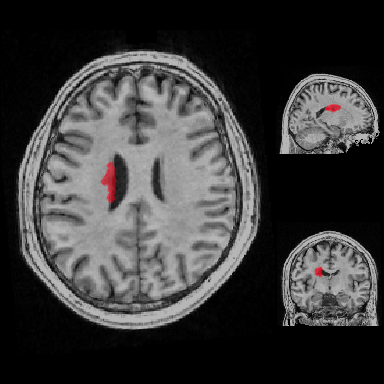

In [265]:
Image.fromarray(gif_image_data[0, 1, :, :, :])

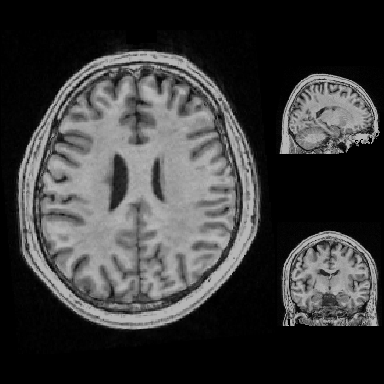

In [266]:
Image.fromarray(gif_image_data[0, 0, :, :, :])